### Imports

In [82]:
import pandas as pd
import os
import numpy as np
import geopandas as gpd
import matplotlib.pyplot as plt
from sklearn.cluster import KMeans
from matplotlib.patches import Patch
from sklearn.decomposition import PCA
from sklearn.preprocessing import MinMaxScaler, StandardScaler
from sklearn.decomposition import TruncatedSVD

### Loading data

In [83]:
# Get the current working directory
current_folder = os.getcwd()

# Move up one folder
project_folder = os.path.abspath(os.path.join(current_folder, '..'))

# Read the data from the pickle files
data_path = project_folder + "/data/raw/"

# Occupation data
occupation_data_1 = pd.read_pickle(data_path + "naics_occupation_part1.pickle")
occupation_data_2 = pd.read_pickle(data_path + "naics_occupation_part2.pickle")
occupation_data_3 = pd.read_pickle(data_path + "naics_occupation_part3.pickle")
occupation_data = pd.concat([occupation_data_1, occupation_data_2, occupation_data_3])

# Industry data
industry_data = pd.read_pickle(data_path + "naics_pattern.pickle")

# GDP data
gdp_data = pd.read_pickle(data_path + "gdp.pickle")

# County data
county_data = pd.read_pickle(data_path + "county.pickle")

# Read the ranking data
ranking_industries = pd.read_excel(data_path + "ranking_industries.xlsx")
ranking_occupations = pd.read_excel(data_path + "ranking_occupations.xlsx")

### Parameters

In [84]:
threshold_for_ranking = 0.5         # The threshold on what data to drop below the threshold
amount_of_features_per_set = 5      # The amount of features to keep per set (three sets: gdp, industry, occupation)

### Generic preperation

In [85]:
def add_zeros(code):
    if len(code) == 3:
        return '00' + code
    elif len(code) == 4:
        return '0' + code
    elif len(code) == 1:
        return '0000' + code
    return code

In [86]:
occupation_data['FIPS'] = occupation_data['FIPS'].astype(str)
industry_data['FIPS'] = industry_data['FIPS'].astype(str)
gdp_data['FIPS'] = gdp_data['FIPS'].astype(str)

occupation_data['FIPS'] = occupation_data['FIPS'].apply(add_zeros)
industry_data['FIPS'] = industry_data['FIPS'].apply(add_zeros)
gdp_data['FIPS'] = gdp_data['FIPS'].apply(add_zeros)

### Occupation data (by Lennard)

#### Preperation

In [87]:
# Convert the data types
occupation_data["naics"] = occupation_data["naics"].astype(str)
occupation_data["OCC_CODE"] = occupation_data["OCC_CODE"].astype(str)
occupation_data["emp_occupation"] = occupation_data["emp_occupation"].astype(int)

ranking_industries["naics"] = ranking_industries["naics"].astype(str)
ranking_occupations["OCC_CODE"] = ranking_occupations["OCC_CODE"].astype(str)

In [88]:
# Group the data by the occupation code, count all fips codes and sum the employment data
occupation_data_overall = occupation_data.groupby(["OCC_CODE", "OCC_TITLE"]).agg({"FIPS": "count", "emp_occupation": "sum"}).reset_index()
occupation_data_overall = occupation_data_overall.rename(columns={"FIPS": "fips_count", "emp_occupation": "emp_occupation_sum"})

# Group the data by naics code and then by occupation code, count all fips codes and sum the employment data
occupation_data_by_industry = occupation_data.groupby(["naics", "NAICS_TITLE", "OCC_CODE", "OCC_TITLE"]).agg({"FIPS": "count", "emp_total_county_naics": "sum", "emp_occupation": "sum"}).reset_index()
occupation_data_by_industry = occupation_data_by_industry.rename(columns={"FIPS": "fips_count", "emp_total_county_naics": "emp_total_county_naics_sum", "emp_occupation": "emp_occupation_sum"})

In [89]:
# Join the overall occupation data with the ranking data
occupation_data_overall = occupation_data_overall.merge(ranking_occupations, on="OCC_CODE", how="left")

# Join the occupation data by industry with the ranking data
occupation_data_by_industry = occupation_data_by_industry.merge(ranking_occupations, on="OCC_CODE", how="left")
occupation_data_by_industry = occupation_data_by_industry.merge(ranking_industries, on="naics", how="left")

In [90]:
# Based on the manual scoring, well drop the rows where score is less than the given threshold


occupation_data_overall = occupation_data_overall[(occupation_data_overall["occupation_score"] > threshold_for_ranking)]
occupation_data_by_industry = occupation_data_by_industry[(occupation_data_by_industry["industry_score"] > threshold_for_ranking) 
                                                          & (occupation_data_by_industry["occupation_score"] > threshold_for_ranking)]

#### Ranking

In [91]:
# Weights for the occupation data by industry
weights_occupation_data_by_industry = {
    "fips_count_rank": 1.0,
    "industry_rank": 1.0,
    "occupation_rank": 1.0,
    "emp_industry_rank": 1.0,
    "emp_occupation_rank": 1.0
}

# Weights for the overall occupation data
weights_occupation_data_overall = {
    "fips_count_rank": 1.0,
    "occupation_rank": 1.0,
    "emp_occupation_rank": 1.0
}

In [92]:
# Create ranking per feature for overall occupation data
occupation_data_overall["fips_count_rank"] = occupation_data_overall["fips_count"].rank(method="dense", ascending=False).astype(int)
occupation_data_overall["occupation_rank"] = occupation_data_overall["occupation_score"].rank(method="dense", ascending=False).astype(int)
occupation_data_overall["emp_occupation_rank"] = occupation_data_overall["emp_occupation_sum"].rank(method="dense", ascending=False).astype(int)

# Calculate the weighted mean for all ranks in the occupation data by industry
occupation_data_overall["overall_rank"] = (
    occupation_data_overall["fips_count_rank"] * weights_occupation_data_overall["fips_count_rank"] +
    occupation_data_overall["occupation_rank"] * weights_occupation_data_overall["occupation_rank"] + 
    occupation_data_overall["emp_occupation_rank"] * weights_occupation_data_overall["emp_occupation_rank"]
) / sum(weights_occupation_data_overall.values())

# Convert the overall rank to double with 2 decimal points
occupation_data_overall["overall_rank"] = occupation_data_overall["overall_rank"].round(2)

# Sort the dataframe and display the top 10 occupations
occupation_data_overall = occupation_data_overall.sort_values("overall_rank")
top_occupations = occupation_data_overall.head(amount_of_features_per_set)

display(top_occupations[["OCC_TITLE", "fips_count_rank" , "occupation_rank", "emp_occupation_rank", "overall_rank"]])

,OCC_TITLE,fips_count_rank,occupation_rank,emp_occupation_rank,overall_rank
61,"Welders, Cutters, Solderers, and Brazers",2,2,2,2.00
39,"Maintenance and Repair Workers, General",1,5,1,2.33
52,Machinists,6,3,3,4.00
36,Industrial Machinery Mechanics,4,3,5,4.00
28,Automotive Service Technicians and Mechanics,8,5,4,5.67


#### Feature DF

In [93]:
# Convert the top then OCC_CODE to a list
top_occupations_list = top_occupations["OCC_CODE"].tolist()

# Filter the data for the top occupations
filtered_occupation_data = occupation_data[occupation_data["OCC_CODE"].isin(top_occupations_list)]

# Pivot table to restructure the data: Rows = FIPS, Columns = OCC_CODE, Values = Sum of emp_occupation
feature_occupation_df = filtered_occupation_data.pivot_table(
    index="FIPS", 
    columns="OCC_CODE", 
    values="emp_occupation", 
    aggfunc="sum",  # Summing values for each FIPS and OCC_CODE
    fill_value=0    # Replace NaN with 0
).reset_index()

# Rename columns for clarity if needed
feature_occupation_df.columns.name = None  # Remove the pivot column grouping name
feature_occupation_df.rename(columns={occ_code: str(occ_code) for occ_code in top_occupations_list}, inplace=True)

# sort by combined sum of all occupation employment columns
feature_occupation_df["total_sum"] = feature_occupation_df.iloc[:, 1:].sum(axis=1)

In [94]:
# Result for the occupations
feature_occupation_df

,FIPS,49-3023,49-9041,49-9071,51-4041,51-4121,total_sum
0,01001,25,11,5,0,6,47
1,01003,125,197,117,125,181,745
2,01005,12,19,11,5,5,52
3,01007,10,31,8,4,6,59
4,01009,22,23,4,21,33,103
...,...,...,...,...,...,...,...
3034,56039,28,3,31,9,58,129
3035,56041,6,12,3,0,18,39
3036,56043,11,2,1,0,1,15
3037,56045,6,5,0,0,2,13


### Industry data (by Ole)

#### Preperation

In [95]:
industry_data_result = industry_data.groupby(['naics', 'DESCRIPTION']).agg(
                est_sum=('est', 'sum'),             # Summe der Werte in der Spalte 'Wert'
                unique_FIPS=('FIPS', 'nunique')     # Anzahl eindeutiger Werte in der Spalte 'Kategorie'
                ).sort_values(by='est_sum', ascending=False)

In [96]:
ranking_industries_new = ranking_industries.set_index('naics')['industry_score'].to_dict()
industry_data['tool_consumption'] = industry_data['naics'].map(ranking_industries_new)
industry_data['tool_consumption'] = industry_data['tool_consumption'].apply(lambda x: round(x,2))

In [97]:
# Remove industries where tool consumption is smaller than 0.5
industry_data = industry_data[industry_data['tool_consumption'] >= threshold_for_ranking].reset_index()

In [98]:
# Share of employment
industry_data.groupby(['naics', 'DESCRIPTION']).agg(
                emp_sum=('emp', 'sum')             # Sum of values in the 'emp' column
                ).sort_values(by='emp_sum', ascending=False).head(5)

,,emp_sum
naics,DESCRIPTION,
2382,Building Equipment Contractors,2171001
5617,Services to Buildings and Dwellings,2004960
8111,Automotive Repair and Maintenance,902870
2381,"Foundation, Structure, and Building Exterior Contractors",901696
2383,Building Finishing Contractors,811812


In [99]:
# Unique fips
industry_data.groupby(['naics', 'DESCRIPTION']).agg(
    unique_FIPS=('FIPS', 'nunique')            # Count of unique values in the 'FIPS' column
      # Count of unique values in the 'category' column
).sort_values(by='unique_FIPS', ascending=False).head(5)

,,unique_FIPS
naics,DESCRIPTION,
2382,Building Equipment Contractors,2756
8111,Automotive Repair and Maintenance,2725
5617,Services to Buildings and Dwellings,2530
2381,"Foundation, Structure, and Building Exterior Contractors",2313
2383,Building Finishing Contractors,2040


#### Ranking

In [100]:
industry_data_result = industry_data.groupby(['naics', 'DESCRIPTION', 'tool_consumption']).agg(
    emp_sum=('emp', 'sum'), # Sum of values in the 'emp' column
    est_sum=('est', 'sum'), # Sum of values in the 'est' column
    unique_FIPS=('FIPS', 'nunique')    # Count of unique values in the 'FIPS' column
).sort_values(by='emp_sum', ascending=False).reset_index()

In [101]:
# Create a copy of the DataFrame
industry_data_result_copy = industry_data_result.copy()

# Calculate rank for all columns starting from 'tool_consumption', with equal values having the same rank
for column in industry_data_result_copy.columns[industry_data_result_copy.columns.get_loc('tool_consumption'):]:
    rank_column_name = f'rank_{column}'
    industry_data_result_copy[rank_column_name] = industry_data_result_copy[column].rank(method='min', ascending=False).astype(int)

# Display the first few rows of the copied data
industry_data_result_copy.head()

,naics,DESCRIPTION,tool_consumption,emp_sum,est_sum,unique_FIPS,rank_tool_consumption,rank_emp_sum,rank_est_sum,rank_unique_FIPS
0,2382,Building Equipment Contractors,1.67,2171001,193562,2756,17,1,2,1
1,5617,Services to Buildings and Dwellings,1.00,2004960,220492,2530,30,2,1,3
2,8111,Automotive Repair and Maintenance,2.33,902870,164584,2725,7,3,3,2
3,2381,"Foundation, Structure, and Building Exterior C...",1.67,901696,101383,2313,17,4,5,4
4,2383,Building Finishing Contractors,1.00,811812,124074,2040,30,5,4,5


In [102]:
weights = {
    'rank_tool_consumption': 0.5,   # Weight for the ranking column 'tool_consumption'
    'rank_emp_sum': 0.25,           # Weight for the ranking column 'emp_sum'
    'rank_est_sum': 0.15,           # Weight for the ranking column 'est_sum'
    'rank_unique_FIPS': 0.1         # Weight for the ranking column 'unique_FIPS'
}

In [103]:
# calculate the weighted sum
industry_data_result_copy['Weighted_Sum'] = (industry_data_result_copy['rank_tool_consumption'] * weights['rank_tool_consumption'] +
                                        industry_data_result_copy['rank_emp_sum'] * weights['rank_emp_sum'] +
                                        industry_data_result_copy['rank_unique_FIPS'] * weights['rank_unique_FIPS'])

result_industry_sorted = industry_data_result_copy.sort_values(by='Weighted_Sum', ascending=True)

In [104]:
# Local parameter to set amount of features in rest
n_rest_industries = 10

In [105]:
# Set NAICS codes of desired industries
top_industries = result_industry_sorted[:amount_of_features_per_set]['naics'].tolist()
rest_industries = result_industry_sorted[amount_of_features_per_set+1:amount_of_features_per_set+n_rest_industries]['naics'].tolist()

#### Feature DF

In [106]:
# Set column for features
feature_column = 'emp'
feature_column_name = 'Employees'

In [107]:
# Assume `df` is the original DataFrame

# Create a new DataFrame with unique FIPS values
feature_pattern_df = pd.DataFrame(industry_data['FIPS'].unique(), columns=['FIPS'])

# Add a new column with the corresponding 'emp' values for the top 5 industries
for naics_code in top_industries:
    # Filter the rows for the current NAICS code and get the corresponding 'emp' values
    feature_column_values = industry_data[industry_data['naics'] == naics_code].set_index('FIPS')[feature_column]
    
    # Merge the 'est' values as a new column in the new DataFrame
    feature_pattern_df = feature_pattern_df.merge(feature_column_values, how='left', left_on='FIPS', right_index=True)
    
    # Rename the column based on the NAICS code
    feature_pattern_df = feature_pattern_df.rename(columns={feature_column: f'{feature_column}_{naics_code}'})

# Add new column with the corresponding aggregated 'emp' value for the top 6 to top 15 industries aggregated
rest_sums = industry_data.loc[industry_data['naics'].isin(rest_industries)].groupby('FIPS')[feature_column].sum() / n_rest_industries
feature_pattern_df = feature_pattern_df.merge(rest_sums, how='left', left_on='FIPS', right_index=True)
feature_pattern_df = feature_pattern_df.rename(columns={feature_column: f'{feature_column}_rest'})

# Set zero values to NaN
feature_pattern_df = feature_pattern_df.replace(0, np.nan)

In [108]:
# Result for the industries
feature_pattern_df

,FIPS,emp_8111,emp_3320A2,emp_2362,emp_3364,emp_2373,emp_rest
0,01001,93.0,NaN,69.0,NaN,NaN,20.1
1,01003,462.0,122.0,356.0,1106.0,182.0,268.6
2,01005,47.0,NaN,NaN,NaN,NaN,46.8
3,01007,38.0,NaN,NaN,NaN,NaN,67.8
4,01009,82.0,95.0,43.0,NaN,57.0,36.5
...,...,...,...,...,...,...,...
3013,56039,99.0,10.0,87.0,NaN,NaN,86.7
3014,56041,27.0,NaN,NaN,NaN,NaN,17.6
3015,56043,44.0,NaN,NaN,NaN,NaN,6.7
3016,56045,26.0,NaN,NaN,NaN,NaN,5.7


### GDP data (by Kristan)

#### Preperation

In [109]:
gdp_data = gdp_data[gdp_data['IndustryClassification'] != '...']

In [110]:
def parse_code_string(code_string):
    """
    Parses a string with numbers and ranges into a list of integers.
    Example: '42,44-46' -> [42, 44, 45, 46]
    """
    result = []
    # Split the string by commas to separate elements
    parts = code_string.split(',')
    
    for part in parts:
        if '-' in part:
            # Handle ranges (e.g., '44-46')
            start, end = map(int, part.split('-'))
            result.extend(range(start, end + 1))  # Add all numbers in the range
        else:
            # Handle single numbers
            result.append(int(part))
    
    return result

In [111]:
gdp_data['IndustryClassificationList'] = gdp_data['IndustryClassification'].apply(parse_code_string)

In [112]:
# ich möchte da wo die top indsutires sind eine neu column als liste die die subsindsutries zurodnert
# was brauche ich: die top industries in der column und die liste aller subcateogires
def generate_sub_industries_from_top_industries(top_industries_list, sub_industries):
    sub_industires = []
    for industry in top_industries_list:
        for sub_industry in sub_industries:
            if sub_industry.startswith(str(industry)):
                sub_industires.append(sub_industry)
    return sub_industires

In [113]:
# for every industry take mean of subIndustryrelvance and then take mean weighted with amout of subindustries, so that in the end i take a mean of subIndustries not of top Industires
sub_industries = ranking_industries['naics'].dropna()
gdp_data['subIndustryClassificationList'] = gdp_data['IndustryClassificationList'].apply(lambda x: generate_sub_industries_from_top_industries(x, sub_industries))

In [114]:
def calc_relevance_out_of_sub_industries(sub_industries, sub_industry_info):
    industry_relevance = sub_industry_info[sub_industry_info['naics'].isin(sub_industries)]
    #industry_relevance = industry_relevance[industry_relevance['Mittelwert'] >= 0.5]
    return (industry_relevance['industry_score'].fillna(0).mean() if not industry_relevance.empty else 0)

In [115]:
gdp_data['IndustryRelevance'] = gdp_data['subIndustryClassificationList'].apply(lambda x: calc_relevance_out_of_sub_industries(x, ranking_industries))
gdp_data['IndustryRelevance'].fillna(0)
gdp_data.head()

,FIPS,GeoName,Region,TableName,LineCode,IndustryClassification,Description,Unit,2017,2018,2019,2020,2021,2022,IndustryClassificationList,subIndustryClassificationList,IndustryRelevance
2,00000,United States,,CAGDP9,3,11,"Agriculture, forestry, fishing and hunting",Thousands of chained 2017 dollars,1.768400e+08,1.841050e+08,1.711490e+08,1.736590e+08,1.837420e+08,1.700580e+08,[11],[1133],1.330000
3,00000,United States,,CAGDP9,6,21,"Mining, quarrying, and oil and gas extraction",Thousands of chained 2017 dollars,2.673020e+08,2.770130e+08,3.146040e+08,3.055880e+08,2.694780e+08,2.452900e+08,[21],"[2111, 2121, 2122, 2123, 2131]",0.398000
4,00000,United States,,CAGDP9,10,22,Utilities,Thousands of chained 2017 dollars,3.137110e+08,3.092690e+08,3.129200e+08,3.323360e+08,3.166030e+08,3.183920e+08,[22],"[2211, 2212]",0.000000
5,00000,United States,,CAGDP9,11,23,Construction,Thousands of chained 2017 dollars,8.402200e+08,8.637550e+08,8.820460e+08,8.564870e+08,8.881040e+08,8.277680e+08,[23],"[2362, 2371, 2373, 2379, 2381, 2382, 2383]",1.762857
6,00000,United States,,CAGDP9,12,31-33,Manufacturing,Thousands of chained 2017 dollars,2.109718e+09,2.213031e+09,2.223326e+09,2.127060e+09,2.248052e+09,2.277757e+09,"[31, 32, 33]","[3119, 3132, 3211, 3212, 3219, 3222, 3231, 324...",1.324000


In [ ]:
# Calculate the average gdp per county over the six years (2017-2022)
gdp_data['avg_gdp'] = gdp_data.iloc[:, 8:14].mean(axis=1)
gdp_data_cut = gdp_data[['FIPS', 'avg_gdp', '2017', '2018', '2019', '2020', '2021', '2022']]

,FIPS,avg_gdp,2017,2018,2019,2020,2021,2022
2,00000,1.765922e+08,1.768400e+08,1.841050e+08,1.711490e+08,1.736590e+08,1.837420e+08,1.700580e+08
3,00000,2.798792e+08,2.673020e+08,2.770130e+08,3.146040e+08,3.055880e+08,2.694780e+08,2.452900e+08
4,00000,3.172052e+08,3.137110e+08,3.092690e+08,3.129200e+08,3.323360e+08,3.166030e+08,3.183920e+08
5,00000,8.597300e+08,8.402200e+08,8.637550e+08,8.820460e+08,8.564870e+08,8.881040e+08,8.277680e+08
6,00000,2.199824e+09,2.109718e+09,2.213031e+09,2.223326e+09,2.127060e+09,2.248052e+09,2.277757e+09
...,...,...,...,...,...,...,...,...
108045,98000,4.741814e+08,4.692329e+08,4.745641e+08,4.790398e+08,4.686524e+08,4.745280e+08,4.790712e+08
108046,98000,7.056750e+07,7.433862e+07,7.342057e+07,7.224680e+07,7.761445e+07,6.730603e+07,5.847854e+07
108047,98000,4.567909e+08,4.461445e+08,4.576763e+08,4.741341e+08,4.674147e+08,4.661462e+08,4.292295e+08
108048,98000,1.782447e+08,1.674685e+08,1.733558e+08,1.814022e+08,1.711564e+08,1.857088e+08,1.903768e+08


In [ ]:
# maximum and minimum avg_gdp
max_gdp = gdp_data_cut['avg_gdp'].max()
min_gdp = gdp_data_cut['avg_gdp'].min()

print("Max GDP: ", max_gdp)
print("Min GDP: ", min_gdp)

Max GDP:  4252997166.6666665
Min GDP:  0.0


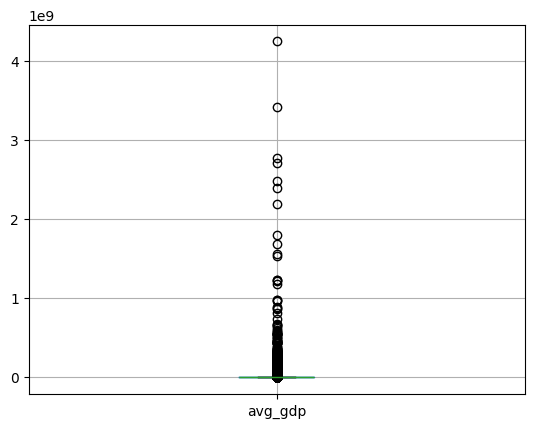

In [130]:
#boxplot of avg_gdp
boxplot = gdp_data_cut.boxplot(column=['avg_gdp'])

In [117]:
print(f'{(len(gdp_data[gdp_data["IndustryRelevance"] <= 0.5]) / len(gdp_data["IndustryRelevance"])):.2%} of rows have industries that are not relevant')
relevance_of_industries = gdp_data.groupby('Description')['IndustryRelevance'].mean().sort_values()

# -> Manufacturing and Information out because it is only Manufacturing
gdp_relevant_industries = relevance_of_industries[relevance_of_industries > 0.5].index
display(gdp_relevant_industries)

# by looking at industries it and their subcategories it seems to be most suitable to select the industires above 0.5 relvance and rate them as equal as we do not know the relvance
# of the other sub industires and how imprtant they are

# filtered by relvance
gdp_data = gdp_data[gdp_data['Description'].isin(gdp_relevant_industries)]
display(gdp_data['Description'].unique())

76.67% of rows have industries that are not relevant


Index(['Natural resources and mining ', '  Manufacturing ',
       'Manufacturing and information ',
       '  Agriculture, forestry, fishing and hunting ',
       '   Durable goods manufacturing ', '  Construction ',
       '  Other services (except government and government enterprises) '],
      dtype='object', name='Description')

array(['  Agriculture, forestry, fishing and hunting ', '  Construction ',
       '  Manufacturing ', '   Durable goods manufacturing ',
       '  Other services (except government and government enterprises) ',
       'Natural resources and mining ', 'Manufacturing and information '],
      dtype=object)

In [118]:
# remove  industries that are caputred in a different industry 
gdp_industries_and_their_sub = gdp_data[['IndustryClassification', 'Description', 'subIndustryClassificationList']].drop_duplicates('IndustryClassification')
gdp_industries_and_their_sub['nSubIndustries'] = gdp_industries_and_their_sub['subIndustryClassificationList'].apply(lambda x: len(x))
display(gdp_industries_and_their_sub)
redundant_industries = ['   Durable goods manufacturing ', 'Manufacturing and information ', 'Natural resources and mining ']

gdp_industries_and_their_sub = gdp_industries_and_their_sub[~gdp_industries_and_their_sub['Description'].isin(redundant_industries)]
display(gdp_industries_and_their_sub)

#filter redundant industries
gdp_data = gdp_data[~gdp_data['Description'].isin(redundant_industries)]
display(gdp_data['Description'].unique())

,IndustryClassification,Description,subIndustryClassificationList,nSubIndustries
2,11,"Agriculture, forestry, fishing and hunting",[1133],1
5,23,Construction,"[2362, 2371, 2373, 2379, 2381, 2382, 2383]",7
6,31-33,Manufacturing,"[3119, 3132, 3211, 3212, 3219, 3222, 3231, 324...",35
7,"321,327-339",Durable goods manufacturing,"[3211, 3212, 3219, 3311, 3312, 3313, 3314, 331...",27
26,81,Other services (except government and govern...,"[8111, 8113]",2
28,"11,21",Natural resources and mining,"[1133, 2111, 2121, 2122, 2123, 2131]",6
31,"31-33,51",Manufacturing and information,"[3119, 3132, 3211, 3212, 3219, 3222, 3231, 324...",35


,IndustryClassification,Description,subIndustryClassificationList,nSubIndustries
2,11,"Agriculture, forestry, fishing and hunting",[1133],1
5,23,Construction,"[2362, 2371, 2373, 2379, 2381, 2382, 2383]",7
6,31-33,Manufacturing,"[3119, 3132, 3211, 3212, 3219, 3222, 3231, 324...",35
26,81,Other services (except government and govern...,"[8111, 8113]",2


array(['  Agriculture, forestry, fishing and hunting ', '  Construction ',
       '  Manufacturing ',
       '  Other services (except government and government enterprises) '],
      dtype=object)

In [119]:
print(gdp_data.columns)
print(gdp_data['Unit'].unique())

# caclualte development for of gdp for each FIPS (with log)
# caclualte aveage development for of gdp for each FIPS
# average god for FIPS

Index(['FIPS', 'GeoName', 'Region', 'TableName', 'LineCode',
       'IndustryClassification', 'Description', 'Unit', '2017', '2018', '2019',
       '2020', '2021', '2022', 'IndustryClassificationList',
       'subIndustryClassificationList', 'IndustryRelevance', 'avg_gdp'],
      dtype='object')
['Thousands of chained 2017 dollars']


In [120]:
industries_per_fips = gdp_data.groupby(['Description'])['FIPS']

In [121]:
years = ['2017', '2018', '2019', '2020', '2021', '2022']
columns_without_years = [item for item in gdp_data.columns if item not in years]
gdp_per_industry = gdp_data.groupby(['FIPS', 'Description'])[years].sum()

display(gdp_per_industry.describe())
gdp_per_industry = gdp_per_industry.replace(0, np.nan)
display(len(gdp_per_industry[(gdp_per_industry.isna()).sum(axis=1) == 0])/len(gdp_per_industry))
display((gdp_per_industry.isna()).sum()/len(gdp_per_industry))

rates = gdp_per_industry.pct_change(axis=1)
years.remove('2017')
rates['averageGrowthPerYear'] = rates[years].mean(axis=1)
gdp_per_industry['averageGrowthPerYear'] = rates['averageGrowthPerYear']
gdp_per_industry['averageGdp']= gdp_per_industry[years].mean(axis=1)

,2017,2018,2019,2020,2021,2022
count,1.271200e+04,1.271200e+04,1.271200e+04,1.271200e+04,1.271200e+04,1.271200e+04
mean,1.114551e+06,1.160613e+06,1.166744e+06,1.116239e+06,1.174158e+06,1.164390e+06
std,2.269103e+07,2.373297e+07,2.388327e+07,2.285720e+07,2.410533e+07,2.416524e+07
min,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00
25%,6.896750e+03,7.053750e+03,6.625750e+03,6.711000e+03,9.082750e+03,8.424500e+03
50%,3.080650e+04,3.126450e+04,3.147300e+04,3.092450e+04,3.681750e+04,3.475650e+04
75%,1.344555e+05,1.384010e+05,1.368485e+05,1.327842e+05,1.435058e+05,1.445568e+05
max,2.109718e+09,2.213031e+09,2.223326e+09,2.127060e+09,2.248052e+09,2.277757e+09


0.7851636249213342

2017    0.130664
2018    0.134125
2019    0.135777
2020    0.133732
2021    0.084330
2022    0.078666
dtype: float64

C:\Users\lenna\AppData\Local\Temp\ipykernel_1624\4274840166.py:10: FutureWarning: The default fill_method='pad' in DataFrame.pct_change is deprecated and will be removed in a future version. Either fill in any non-leading NA values prior to calling pct_change or specify 'fill_method=None' to not fill NA values.
  rates = gdp_per_industry.pct_change(axis=1)


#### Feature DF

In [122]:
gdp_per_industry = gdp_per_industry.reset_index()
gdp_per_industry = gdp_per_industry.drop(columns=years)

# Pivot the 'Description' column for 'averageGrowthPerYear'
pivoted_growth = gdp_per_industry.pivot(index='FIPS', columns='Description', values='averageGrowthPerYear')

# Rename the columns with the suffix `_averageGrowthPerYear`
pivoted_growth.columns = [f"{col}_averageGrowthPerYear" for col in pivoted_growth.columns]

# (Optional) Pivot for 'averageGDP' or other metrics
pivoted_gdp = gdp_per_industry.pivot(index='FIPS', columns='Description', values='averageGdp')
pivoted_gdp.columns = [f"{col}_averageGdp" for col in pivoted_gdp.columns]

# Merge the pivoted DataFrames back together if needed
feature_gdp_df = pivoted_growth.join(pivoted_gdp, how='outer')
feature_gdp_df = feature_gdp_df.replace(0, np.nan)

In [123]:
# Result for gdp
feature_gdp_df

,"Agriculture, forestry, fishing and hunting _averageGrowthPerYear",Construction _averageGrowthPerYear,Manufacturing _averageGrowthPerYear,Other services (except government and government enterprises) _averageGrowthPerYear,"Agriculture, forestry, fishing and hunting _averageGdp",Construction _averageGdp,Manufacturing _averageGdp,Other services (except government and government enterprises) _averageGdp
FIPS,,,,,,,,
00000,-0.006207,-0.002163,0.016084,0.001728,176542600.0,863632000.0,2.217845e+09,431672200.0
01000,-0.001174,0.021765,0.015612,0.006939,2214806.6,9823717.8,3.667333e+07,5612676.8
01001,-0.070595,0.022538,-0.053013,0.017800,28145.8,69898.2,2.474136e+05,50074.2
01003,0.097344,0.062566,0.065879,0.030923,38184.8,619919.4,5.392026e+05,276627.4
01005,0.037188,0.005257,0.003368,-0.026532,48977.8,16616.2,1.921452e+05,19761.5
...,...,...,...,...,...,...,...,...
94000,0.039415,-0.004578,0.018854,0.001015,36522721.8,55851096.0,1.663621e+08,27657634.0
95000,-0.016837,0.009717,0.009103,0.009750,30204806.6,206882201.2,4.935401e+08,101153877.2
96000,-0.068527,0.000197,0.019433,0.011885,14404024.8,118114328.8,2.602015e+08,49054198.4


### Merging the data

In [124]:
county_data.rename(columns={'GEOID': 'FIPS'}, inplace=True)
county_data = county_data[['FIPS', 'NAME']]	

# Merge the dataframes
master_df = county_data.merge(feature_occupation_df, on='FIPS', how='left')
master_df = master_df.merge(feature_pattern_df, on='FIPS', how='left')
master_df = master_df.merge(feature_gdp_df, on='FIPS', how='left')

display(master_df)

,FIPS,NAME,49-3023,49-9041,49-9071,51-4041,51-4121,total_sum,emp_8111,emp_3320A2,...,emp_2373,emp_rest,"Agriculture, forestry, fishing and hunting _averageGrowthPerYear",Construction _averageGrowthPerYear,Manufacturing _averageGrowthPerYear,Other services (except government and government enterprises) _averageGrowthPerYear,"Agriculture, forestry, fishing and hunting _averageGdp",Construction _averageGdp,Manufacturing _averageGdp,Other services (except government and government enterprises) _averageGdp
0,21007,Ballard,2.0,0.0,0.0,0.0,0.0,2.0,9.0,NaN,...,NaN,1.9,0.042182,-0.215712,0.269646,-0.025438,35887.4,1.161020e+04,44015.0,4735.0
1,21017,Bourbon,4.0,1.0,1.0,22.0,5.0,33.0,16.0,NaN,...,NaN,15.0,-0.041303,-0.059329,0.033172,0.030290,322148.0,2.204760e+04,121010.8,17590.6
2,21031,Butler,15.0,22.0,23.0,3.0,1.0,64.0,52.0,NaN,...,NaN,2.5,0.038799,-0.023657,-0.009590,-0.004834,22111.4,1.280520e+04,100651.2,10179.0
3,21065,Estill,3.0,0.0,0.0,0.0,0.0,3.0,12.0,NaN,...,NaN,0.1,0.054518,-0.063652,NaN,-0.018318,478.0,6.482400e+03,NaN,7640.2
4,21069,Fleming,8.0,0.0,1.0,0.0,0.0,9.0,30.0,NaN,...,NaN,7.8,-0.094425,0.085235,0.035808,-0.011552,18195.0,3.183467e+04,43305.4,10940.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
3228,31073,Gosper,0.0,0.0,0.0,0.0,0.0,0.0,NaN,NaN,...,NaN,NaN,0.414574,NaN,NaN,0.001355,11973.2,NaN,NaN,2167.0
3229,39075,Holmes,42.0,71.0,160.0,102.0,227.0,602.0,161.0,1181.0,...,43.0,251.7,0.021851,0.036787,0.019503,0.018432,151736.8,3.545352e+05,801153.4,59932.8
3230,48171,Gillespie,21.0,1.0,5.0,10.0,11.0,48.0,78.0,5.0,...,134.0,61.7,0.037976,0.030826,0.078970,0.030652,5433.6,1.088082e+05,91590.4,34533.0
3231,55079,Milwaukee,676.0,1266.0,1258.0,1019.0,2191.0,6410.0,2330.0,2054.0,...,116.0,1583.8,0.143878,-0.012687,-0.008885,-0.007979,3960.0,1.344597e+06,6804457.4,1326805.8


### Scaling

Done individually in each sub notebook